In [1]:
import pandas as pd
import numpy as np
from sklearn import ensemble, linear_model, tree
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.datasets import fetch_california_housing
from sklearn import ensemble
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Read data FBPS-ValidationData.csv
data = pd.read_csv('/content/drive/My Drive/Explainable ML/FBPS-ValidationData.csv',sep='\t')
# Why is it necessary to make a copy of the read data?
# because we will edit in the data, we don't want to change the original data


In [4]:
# Change output into the following form:
"""If birthpos == 1 -> y = 1
If birthpos == lastchild -> y = 3
Else -> y = 2"""
# TODO: sometimes there's 0 in either birthpos or birthn , sometimes birthpos> birthn
y =np.array(data["birthpos"].copy())
for i in range(len(y)):
    if y[i] == 1:
        continue # first born
    elif y[i] == data["birthn"][i]:
        y[i] = 3 # last born
    else:
        y[i] = 2 # middle born


In [5]:
# Select only probands with native language English
print("Native english speaking:\n", data["engnat"].head(10))


Native english speaking:
 0    1
1    2
2    2
3    1
4    1
5    1
6    1
7    1
8    2
9    1
Name: engnat, dtype: int64


In [6]:
# Which columns can you delete?
# target feature: birthpos
# matters only to update birthpos: birthn
# almost all empty values: AGR10	CSN1	CSN2	CSN3	CSN4	CSN5	CSN6	CSN7	CSN8	CSN9	CSN10	OPN1	OPN2	OPN3	OPN4	OPN5	OPN6	OPN7	OPN8	OPN9	OPN10	country	dateload	source	screensize	introelapse	testelapse	endelapse
# TODO : don't think it really matters, if we take it we must convert it : submittime
x =  data.copy()
x = x.drop(['birthpos', 'birthn','AGR10', 'CSN1', 'CSN2',
            'CSN3', 'CSN4', 'CSN5', 'CSN6', 'CSN7', 'CSN8',
            'CSN9', 'CSN10', 'OPN1', 'OPN2', 'OPN3', 'OPN4',
            'OPN5', 'OPN6', 'OPN7', 'OPN8', 'OPN9', 'OPN10',
            'country', 'dateload', 'source', 'screensize',
            'introelapse', 'testelapse', 'endelapse',
            'submittime'
            ], axis=1)


# Use the RandomForestClassifier() for the prediction
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15)
classifier = ensemble.RandomForestClassifier(max_depth=10, random_state=0)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)


In [7]:
# Print accuracy and confusion matrix
cm = confusion_matrix(y_test, y_pred) # 3x3 because we have 3 possibilites 1 2 3
#print("Y:\n", y[:30])
print("Classification without feature reduction:")
print('confusion_matrix\n',cm)
print('Accuracy: \n' + str(accuracy_score(y_test, y_pred))) # TODO: always predicting first born with small depth?


Classification without feature reduction:
confusion_matrix
 [[3076    0   37]
 [1269    1   30]
 [1816    0   48]]
Accuracy: 
0.4978492910626095


In [8]:
# Reduce features using LinearDiscriminantAnalysis
lda = LDA(n_components=2)
x_train2 = lda.fit_transform(x_train,y_train) # TODO: have to comment it or feature importance won't work
x_test2= lda.transform(x_test)
classifier.fit(x_train2, y_train)
y_pred2 = classifier.predict(x_test2)
cm = confusion_matrix(y_test, y_pred2)
print("After feature reduction using LDA:")
print('confusion_matrix\n',cm)
print('Accuracy: \n' + str(accuracy_score(y_test, y_pred2))) # TODO: accuracy didn't change that much?


After feature reduction using LDA:
confusion_matrix
 [[2923   25  165]
 [1176   21  103]
 [1686   17  161]]
Accuracy: 
0.49466305559980883


In [9]:
# Compare the results without and with using LDA
# done using printing

# Is the dataset balanced? Why or why not?
# TODO: don't think so, weight more for first born in all 3 classes

# Compare accuracy and balanced accuracy
bal_acc = balanced_accuracy_score(y_test, y_pred)
print("balanced accuracy:", bal_acc)


balanced accuracy: 0.3382115542898994


In [10]:
# Create the 3 Tree-based models from the lecture
class_models = {'random_forest':{'model':ensemble.RandomForestClassifier(max_depth=10)},
                'decision_tree':{'model': tree.DecisionTreeClassifier(max_depth=7, random_state=9)},
                'gradient_boosting':{'model':ensemble.GradientBoostingClassifier(n_estimators=210)},
                'logistic':{'model': linear_model.LogisticRegression()},
                'lda':{'model': LDA(n_components=2)}
                }


# Fit them with the training data
for model_name in class_models.keys():
    fitted_model = class_models[model_name]['model'].fit(x_train, y_train)
    class_models[model_name]['fitted'] = fitted_model
# Compute feature importance
#print("XXXX", x_train)
dt_imp_df = pd.DataFrame({'name': x_train.columns,
                          'dt_imp': class_models['decision_tree']['fitted'].feature_importances_})
gb_imp_df = pd.DataFrame({'name': x_train.columns,
                          'gb_imp': class_models['gradient_boosting']['fitted'].feature_importances_})
rf_imp_df = pd.DataFrame({'name': x_train.columns,
                          'rf_imp': class_models['random_forest']['fitted'].feature_importances_})


# Rank it
dt_rank_df = pd.DataFrame({'dt_rank': dt_imp_df['dt_imp'].rank(method='first', ascending=False).astype(int)})
gb_rank_df = pd.DataFrame({'gb_rank': gb_imp_df['gb_imp'].rank(method='first', ascending=False).astype(int)})
rf_rank_df = pd.DataFrame({'rf_rank': rf_imp_df['rf_imp'].rank(method='first', ascending=False).astype(int)})

tree_ranks_df = pd.merge(
                    pd.merge(
                        pd.concat((dt_imp_df,dt_rank_df),axis=1),
                        pd.concat((gb_imp_df,gb_rank_df),axis=1),
                        'left'
                    ),
                    pd.concat((rf_imp_df,rf_rank_df),axis=1),
                    'left'
                )
tree_ranks_df['avg_rank'] = (tree_ranks_df['dt_rank']
                             +tree_ranks_df['gb_rank']
                             +tree_ranks_df['rf_rank']) /3
print('Ranked Feature importance tree based models\n', tree_ranks_df.sort_values(by='avg_rank')) # TODO: in lecture, why didn't he drop birthpos, birthn?


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Ranked Feature importance tree based models
       name    dt_imp  dt_rank    gb_imp  gb_rank    rf_imp  rf_rank   avg_rank
0       Q1  0.150443        1  0.059269        2  0.029037        2   1.666667
26     age  0.081008        3  0.087374        1  0.049222        1   1.666667
6       Q7  0.080541        4  0.037473        4  0.023022        3   3.666667
9      Q10  0.040477        6  0.028352        6  0.020858        5   5.666667
15     Q16  0.030761        8  0.032642        5  0.022778        4   5.666667
11     Q12  0.043579        5  0.027056        9  0.019387        8   7.333333
12     Q13  0.030678        9  0.027398        7  0.020302        7   7.666667
19     Q20  0.039579        7  0.022834       10  0.018425       10   9.000000
3       Q4  0.026032       12  0.021811       11  0.018559        9  10.666667
7       Q8  0.008436       32  0.027288        8  0.020596        6  15.333333
37    EXT9  0.014492       19  0.020910       12  0.017132       19  16.666667
27  eng

In [11]:
# Print the cardinality of the features gender and I sometimes ruin my jokes by laughing in the middle of them Q25
print('Cardinality of gender', x_train['gender'].unique().shape) # TODO: isn't it suppose to be only 3?
print('Cardinality of Q25', x_train['Q25'].unique().shape) # TODO: isn't it suppose to be only 5?
print("===============================================")

# Compute coefficients of LDA
# TODO
print(class_models['logistic']['fitted'].coef_.shape)


# Normalize the coefficients
stdv = np.std(x_train, 0)
lr_imp_df = pd.DataFrame({'name':x_train.columns,
                          'first_coef_norm':class_models['logistic']['fitted'].coef_[0]*stdv,
                          'middle_coef_norm':class_models['logistic']['fitted'].coef_[1]*stdv,
                          'last_coef_norm':class_models['logistic']['fitted'].coef_[2]*stdv,
                          }).reset_index(drop=True)


# How much each class is represented in the model?
class_priors = class_models['lda']['fitted'].priors_
print(class_priors)


Cardinality of gender (4,)
Cardinality of Q25 (6,)
(3, 58)
[0.49088966 0.2081037  0.30100664]


In [12]:
# Print weighted features sorted into a HTML table
lr_imp_df['coef_weighted_avg'] = (abs(lr_imp_df['first_coef_norm'])*class_priors[0]) + (abs(lr_imp_df['middle_coef_norm'])*class_priors[1]) + (abs(lr_imp_df['last_coef_norm'])*class_priors[2])
table_lr_imp = lr_imp_df.sort_values(by='coef_weighted_avg', ascending=False).style.background_gradient(cmap='viridis', low=-0.1, high=0.1,subset=['first_coef_norm', 'middle_coef_norm', 'last_coef_norm'])
#table_lr_imp = lr_imp_df.sort_values(by='coef_weighted_avg', ascending=False).style.background_gradient(cmap='viridis', low=-0.1, high=0.1,subset=['first_coef_norm','middle_coef_norm', 'last_coef_norm'])
#print("Weighted Feature Importance Logistic Regreesion\n",table_lr_imp.to_html())
#print("Weighted Feature Importance Logistic Regreesion\n",table_lr_imp)

# Who doesn't insult people? AGR3
ans = lr_imp_df.loc[lr_imp_df['name'] == 'AGR3', ['first_coef_norm', 'middle_coef_norm', 'last_coef_norm']].idxmin(axis=1).values[0]
if ans == 'first_coef_norm':
    ans = 'first born'
elif ans == 'middle_coef_norm':
    ans = 'middle born'
else:
    ans = 'last born'
print("Who doesn't insult people?\n", ans)


Who doesn't insult people?
 first born


In [13]:
# Who doesn't boss people around? Q13
ans = lr_imp_df.loc[lr_imp_df['name'] == 'Q13', ['first_coef_norm', 'middle_coef_norm', 'last_coef_norm']].idxmin(axis=1).values[0]
if ans == 'first_coef_norm':
    ans = 'first born'
elif ans == 'middle_coef_norm':
    ans = 'middle born'
else:
    ans = 'last born'
print("Who doesn't boss people around?\n", ans)


Who doesn't boss people around?
 last born


In [14]:
# What is the advantage of Permutation Feature Importance and why?
"""
measures the increase in prediction error after the
values of each feature have been mixed (within the
feature)
- Permutation importance is calculated after a model has been fitted
- we won't change the model
- Traditional models compute feature importance from training data
- PFI computes feature importance from unseen/new (mixed columns) data
"""

"""# Read the fetch_california_housing data
x, y= fetch_california_housing(return_X_y= True, as_frame=True)

# Use only 100 datasets
x = x.iloc[:100, :]
y = y[:100]
#print(x.shape)
#print(y.shape)


# Use RandomForestRegressor
model = ensemble.RandomForestRegressor(n_estimators=100)
model.fit(x, y)"""


# The target variable is the median house value
""" # TODO: yes?
 0     4.526
1     3.585
2     3.521
3     3.413
4     3.422
      ...
95    1.300
96    1.838
97    1.250
98    1.700
99    1.931
Name: MedHouseVal, Length: 100, dtype: float64
"""

' # TODO: yes?\n 0     4.526\n1     3.585\n2     3.521\n3     3.413\n4     3.422\n      ...  \n95    1.300\n96    1.838\n97    1.250\n98    1.700\n99    1.931\nName: MedHouseVal, Length: 100, dtype: float64\n'

X
     MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0   8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1   8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2   7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3   5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4   3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   
..     ...       ...       ...        ...         ...       ...       ...   
95  2.0096      36.0  2.294016   1.066294      3469.0  1.493328     37.80   
96  2.8345      31.0  3.894915   1.127966      2048.0  1.735593     37.82   
97  2.0062      29.0  3.681319   1.175824       202.0  2.219780     37.81   
98  1.2185      22.0  2.945600   1.016000      2024.0  1.619200     37.82   
99  2.6104      37.0  3.707143   1.107143      1838.0  1.875510     37.82   

    Longitude  
0     -122.23  
1     -122.22  
2     -122.24  
3     -1

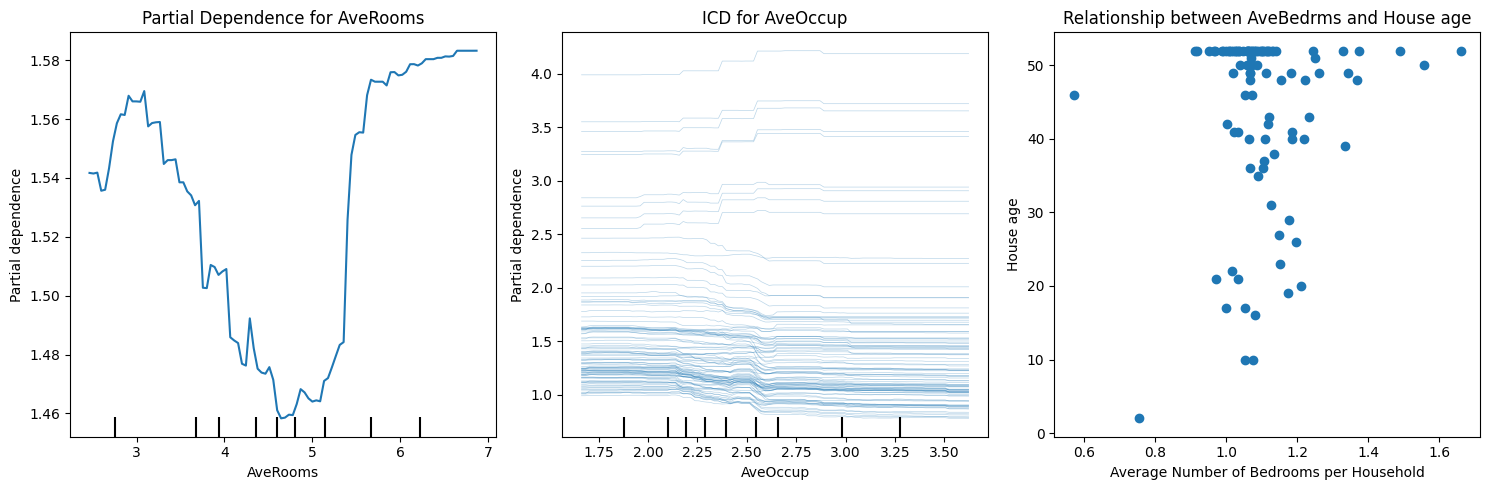

In [15]:
x, y= fetch_california_housing(return_X_y= True, as_frame=True)

# Use only 100 datasets
x = x[:100]
y = y[:100]
print("X\n",x)
print("Y\n",y)

# Use RandomForestRegressor
rf = ensemble.RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(x, y)

# The target variable is the median house value
""" # TODO: yes?
 0     4.526
1     3.585
2     3.521
3     3.413
4     3.422
      ...
95    1.300
96    1.838
97    1.250
98    1.700
99    1.931
Name: MedHouseVal, Length: 100, dtype: float64
"""

# Plot PDP of the feature average number of rooms per household: AveRooms
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
tree_disp = PartialDependenceDisplay.from_estimator(rf, x, ["AveRooms"], ax=axes[0])
axes[0].set_title('Partial Dependence for AveRooms')


# Plot ICD of the feature average number of household members: AveOccup
icd = PartialDependenceDisplay.from_estimator(rf, x, ["AveOccup"], ax=axes[1], kind='individual')
axes[1].set_title('ICD for AveOccup')



# Plot the relationship between average number of bedrooms per household and median house age
axes[2].scatter(x['AveBedrms'], x['HouseAge'])
axes[2].set_xlabel('Average Number of Bedrooms per Household')
axes[2].set_ylabel('House age')
axes[2].set_title('Relationship between AveBedrms and House age')

plt.tight_layout()
plt.show()

In [16]:
import pandas as pd
import numpy as np

data = {
    'x': [5, 15, 25, np.nan]  # Creating a dictionary with 'x' column and values
}

df = pd.DataFrame(data)  # Creating a DataFrame from the dictionary
print(df['x'].mean())
print(np.mean(df['x']))
#print([5, 15, 25, np.nan].value)
#print(df)

15.0
15.0


In [17]:
x, y= fetch_california_housing(return_X_y= True, as_frame=True)

# Use only 100 datasets
x = x[:100]
y = y[:100]
print("X\n",x)
print("Y\n",y)


X
     MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0   8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1   8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2   7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3   5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4   3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   
..     ...       ...       ...        ...         ...       ...       ...   
95  2.0096      36.0  2.294016   1.066294      3469.0  1.493328     37.80   
96  2.8345      31.0  3.894915   1.127966      2048.0  1.735593     37.82   
97  2.0062      29.0  3.681319   1.175824       202.0  2.219780     37.81   
98  1.2185      22.0  2.945600   1.016000      2024.0  1.619200     37.82   
99  2.6104      37.0  3.707143   1.107143      1838.0  1.875510     37.82   

    Longitude  
0     -122.23  
1     -122.22  
2     -122.24  
3     -1

Text(0.5, 1.0, 'Partial Dependence for AveRooms')

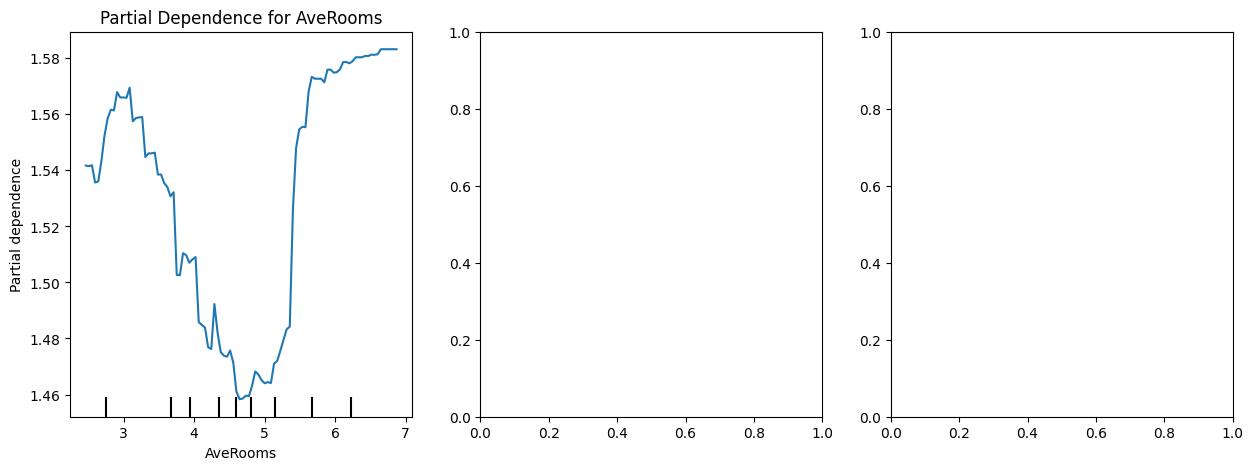

In [18]:
# Use RandomForestRegressor
rf = ensemble.RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(x, y)

# The target variable is the median house value
""" # TODO: yes?
 0     4.526
1     3.585
2     3.521
3     3.413
4     3.422
      ...
95    1.300
96    1.838
97    1.250
98    1.700
99    1.931
Name: MedHouseVal, Length: 100, dtype: float64
"""

# Plot PDP of the feature average number of rooms per household: AveRooms
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
tree_disp = PartialDependenceDisplay.from_estimator(rf, x, ["AveRooms"], ax=axes[0])
axes[0].set_title('Partial Dependence for AveRooms')


In [25]:
# Plot ICD of the feature average number of household members: AveOccup
icd = PartialDependenceDisplay.from_estimator(rf, x, ["AveOccup"], ax=axes[1], kind='individual')
axes[1].set_title('ICD for AveOccup')



# Plot the relationship between average number of bedrooms per household and median house age
axes[2].scatter(x['AveBedrms'], x['HouseAge'])
axes[2].set_xlabel('Average Number of Bedrooms per Household')
axes[2].set_ylabel('House age')
axes[2].set_title('Relationship between AveBedrms and House age')

plt.tight_layout()
plt.show()

ValueError: ignored

In [21]:
x, y= fetch_california_housing(return_X_y= True, as_frame=True)

# Use only 100 datasets
x = x[:100]
y = y[:100]
print("X\n",x)
print("Y\n",y)


X
     MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0   8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1   8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2   7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3   5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4   3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   
..     ...       ...       ...        ...         ...       ...       ...   
95  2.0096      36.0  2.294016   1.066294      3469.0  1.493328     37.80   
96  2.8345      31.0  3.894915   1.127966      2048.0  1.735593     37.82   
97  2.0062      29.0  3.681319   1.175824       202.0  2.219780     37.81   
98  1.2185      22.0  2.945600   1.016000      2024.0  1.619200     37.82   
99  2.6104      37.0  3.707143   1.107143      1838.0  1.875510     37.82   

    Longitude  
0     -122.23  
1     -122.22  
2     -122.24  
3     -1

Text(0.5, 1.0, 'Partial Dependence for AveRooms')

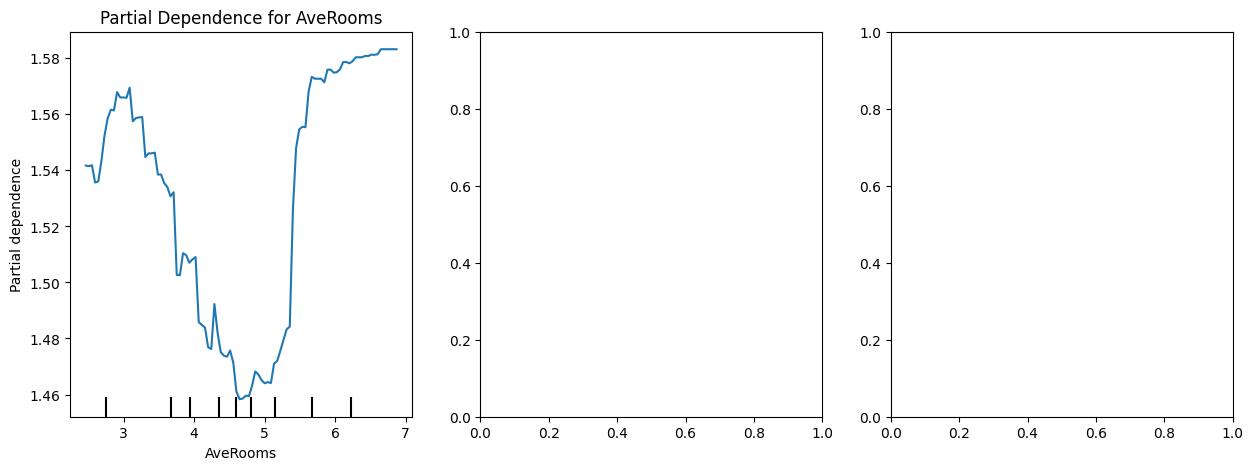

In [22]:
# Use RandomForestRegressor
rf = ensemble.RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(x, y)

# The target variable is the median house value
""" # TODO: yes?
 0     4.526
1     3.585
2     3.521
3     3.413
4     3.422
      ...
95    1.300
96    1.838
97    1.250
98    1.700
99    1.931
Name: MedHouseVal, Length: 100, dtype: float64
"""

# Plot PDP of the feature average number of rooms per household: AveRooms
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
tree_disp = PartialDependenceDisplay.from_estimator(rf, x, ["AveRooms"], ax=axes[0])
axes[0].set_title('Partial Dependence for AveRooms')


In [23]:
# Plot ICD of the feature average number of household members: AveOccup
icd = PartialDependenceDisplay.from_estimator(rf, x, ["AveOccup"], ax=axes[1], kind='individual')
axes[1].set_title('ICD for AveOccup')



# Plot the relationship between average number of bedrooms per household and median house age
axes[2].scatter(x['AveBedrms'], x['HouseAge'])
axes[2].set_xlabel('Average Number of Bedrooms per Household')
axes[2].set_ylabel('House age')
axes[2].set_title('Relationship between AveBedrms and House age')

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>